In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Source").getOrCreate()

In [2]:
from __future__ import print_function

import seaborn as sns
import matplotlib.pyplot as plt
import imblearn
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
import math 
import pyspark.sql.functions as F

In [3]:
rawData = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("./healthcare-dataset-stroke-data.csv")
rawData.printSchema()
rawData.count()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



5110

In [10]:
rawData.groupBy('gender').count().orderBy('gender', ascending=False).show()

+------+-----+
|gender|count|
+------+-----+
| Other|    1|
|  Male| 2115|
|Female| 2994|
+------+-----+



In [11]:
rawData.groupBy('hypertension').count().orderBy('hypertension', ascending=False).show()

+------------+-----+
|hypertension|count|
+------------+-----+
|           1|  498|
|           0| 4612|
+------------+-----+



In [12]:
rawData.groupBy('heart_disease').count().orderBy('heart_disease', ascending=False).show()

+-------------+-----+
|heart_disease|count|
+-------------+-----+
|            1|  276|
|            0| 4834|
+-------------+-----+



In [13]:
rawData.groupBy('ever_married').count().orderBy('ever_married', ascending=False).show()

+------------+-----+
|ever_married|count|
+------------+-----+
|         Yes| 3353|
|          No| 1757|
+------------+-----+



In [14]:
rawData.groupBy('work_type').count().orderBy('work_type', ascending=False).show()

+-------------+-----+
|    work_type|count|
+-------------+-----+
|     children|  687|
|Self-employed|  819|
|      Private| 2925|
| Never_worked|   22|
|     Govt_job|  657|
+-------------+-----+



In [15]:
rawData.groupBy('Residence_type').count().orderBy('Residence_type', ascending=False).show()

+--------------+-----+
|Residence_type|count|
+--------------+-----+
|         Urban| 2596|
|         Rural| 2514|
+--------------+-----+



In [16]:
rawData.groupBy('smoking_status').count().orderBy('smoking_status', ascending=False).show()

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|         smokes|  789|
|   never smoked| 1892|
|formerly smoked|  885|
|        Unknown| 1544|
+---------------+-----+



In [17]:
rawData.groupBy('stroke').count().orderBy('stroke', ascending=False).show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



In [22]:
rawData.select('bmi').filter(rawData['bmi']!= "N/A").toPandas().astype(float).describe()

,bmi
count,4908.00000
mean,28.89456
std,7.85432
min,10.30000
25%,23.50000
50%,28.10000
75%,33.10000
max,97.60000


In [4]:
rawData = rawData.filter(rawData['bmi'] != "N/A")
rawData = rawData.filter(rawData['gender'] != "Other")
rawData.count()

4908

In [5]:
rawData = rawData.drop('id')
rawData.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [6]:
Data = rawData.withColumn('ever_married', F.when(rawData['ever_married'] == "Yes", 1)\
                        .otherwise(0))
Data = Data.withColumn('gender', F.when(rawData['gender'] == 'Male', 1)\
                       .otherwise(0))
Data = Data.withColumn('Residence_type', F.when(rawData['Residence_type'] == 'Urban', 1)\
                       .otherwise(0))
Data = Data.withColumn('work_type', F.when(rawData['work_type'] == 'Never_worked', 0)\
                       .when(rawData['work_type'] == 'children', 1)\
                       .when(rawData['work_type'] == 'Private', 2)\
                       .when(rawData['work_type'] == 'Govt_job', 3)\
                       .when(rawData['work_type'] == 'Self-employed', 4))
Data = Data.withColumn('smoking_status', F.when(rawData['smoking_status'] == 'Unknown', 0)\
                       .when(rawData['smoking_status'] == 'never smoked', 1)\
                       .when(rawData['smoking_status'] == 'smokes', 2)\
                       .when(rawData['smoking_status'] == 'formerly smoked', 3))
Data.count()

4908

In [7]:
print ("So lan xuat hien cua stroke la 0: ",Data.filter(Data['stroke'] == 0).count())
print ("So lan xuat hien cua stroke la 1: ",Data.filter(Data['stroke'] == 1).count())

So lan xuat hien cua stroke la 0:  4699
So lan xuat hien cua stroke la 1:  209


In [8]:
X = Data.drop('stroke')
Y = Data.select('stroke')
stk = SMOTE(random_state=42)
X_res,y_res = stk.fit_resample(X.toPandas(),Y.toPandas())
joinDF = pd.concat([X_res, y_res], axis=1, join="inner")
balancedData = spark.createDataFrame(joinDF)
print ("So lan xuat hien cua stroke la 0: ",balancedData.filter(balancedData['stroke'] == 0).count())
print ("So lan xuat hien cua stroke la 1: ",balancedData.filter(balancedData['stroke'] == 1).count())

So lan xuat hien cua stroke la 0:  4699
So lan xuat hien cua stroke la 1:  4699


In [51]:
balancedData.filter(balancedData['stroke'] == 1).show(300)

+------+------------------+------------+-------------+------------+---------+--------------+------------------+------------------+--------------+------+
|gender|               age|hypertension|heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|stroke|
+------+------------------+------------+-------------+------------+---------+--------------+------------------+------------------+--------------+------+
|     1|              67.0|           0|            1|           1|        2|             1|            228.69|              36.6|             3|     1|
|     1|              80.0|           0|            1|           1|        2|             0|            105.92|              32.5|             1|     1|
|     0|              49.0|           0|            0|           1|        2|             1|            171.23|              34.4|             2|     1|
|     0|              79.0|           1|            0|           1|        4|     

In [18]:
trainData, testData = balancedData.randomSplit([0.7, 0.3])
print("So dong trong train data:", trainData.count())
print("So dong trong test data:", testData.count())

So dong trong train data: 6591
So dong trong test data: 2807


In [20]:
trainData.show(5)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
|     0|0.08|           0|            0|           0|        1|             1|           139.67|14.1|             0|     0|
|     0|0.32|           0|            0|           0|        1|             0|            55.86|16.0|             0|     0|
|     0|0.32|           0|            0|           0|        1|             0|            73.71|16.2|             0|     0|
|     0|0.32|           0|            0|           0|        1|             1|           108.63|19.6|             0|     0|
|     0| 0.4|           0|            0|           0|        1|             0|            85.65|17.4|             0|     0|
+------+

In [21]:
testData.show(5)

+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|
+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
|     0|0.72|           0|            0|           0|        1|             0|            62.13|16.8|             0|     0|
|     0| 1.0|           0|            0|           0|        1|             1|           199.83|24.5|             0|     0|
|     0|1.08|           0|            0|           0|        1|             1|           159.39|12.8|             0|     0|
|     0|1.16|           0|            0|           0|        1|             1|            60.98|17.2|             0|     0|
|     0|1.32|           0|            0|           0|        1|             0|            75.22|18.6|             0|     0|
+------+

In [37]:
def mean(dataset, column):
    return (dataset.groupBy().mean(column).collect())[0][0]

In [38]:
def stdev(dataset, column):
    avg = mean(dataset, column)
    lendf = len(dataset.select(column).collect())
    value = dataset.select(column).rdd.flatMap(lambda x:x).collect()
    variance = sum([(x-avg)**2 for x in value]) / float(lendf - 1)
    return math.sqrt(variance)

In [39]:
def summarize_dataset(dataset):
    summaries = [(mean(dataset,column), stdev(dataset,column), dataset.select(column).count())\
                 for column in dataset.columns]
    del(summaries[-1])
    return summaries

In [40]:
def summarize_by_class(dataset):
    summaries = dict()
    lenstroke = len(dataset.select('stroke').rdd.flatMap(lambda x:x).distinct().collect())
    for i in range(0,lenstroke):
        item = dataset.select('stroke').rdd.flatMap(lambda x:x).distinct().collect()[i]
        res = dataset.filter(dataset.stroke == item)
        summaries[item] = summarize_dataset(res)
    return summaries

In [41]:
def calculate_probability(x, mean, stdev):
    exponent = math.exp(-((x-mean)**2 / (2 * stdev**2)))
    return (1 / (math.sqrt(2 * math.pi) * stdev)) * exponent

In [42]:
def calculate_class_probability(summaries, row):
    totalRows = sum([summaries[label][0][2] for label in summaries])
    probabilities = dict()
    for class_value, class_summaries in summaries.items():
        probabilities[class_value] = summaries[class_value][0][2] / float(totalRows)
        for i in range(0, len(class_summaries)):
            mean, stdev, _ = class_summaries[i]
            probabilities[class_value] *= calculate_probability(row[i], mean, stdev)  
    return probabilities

In [43]:
def predict(summaries, row):
    probabilites = calculate_class_probability(summaries, row)
    best_label, best_prob = None, -1
    for class_value, probability in probabilites.items():
        if (best_label is None or probability > best_prob):
            best_prob = probability
            best_label = class_value
    return best_label

In [44]:
def naive_bayes(train, test):
    summerize = summarize_by_class(train)
    predictions = list()
    for row in test.collect():
        output = predict(summerize, row)
        predictions.append(output)
    return predictions

In [45]:
def accuracy_metric(actual, predict):
    correct = 0
    for i in range(len(actual)):
        if (actual[i] == predict[i]):
            correct += 1
    return correct / float(len(actual)) * 100

In [46]:
from sklearn.metrics import confusion_matrix
def evaluate_algorithm(trainData, testData, algorithm):
    predicted = algorithm(trainData,testData)
    actual = testData.select('stroke').rdd.flatMap(lambda x: x).collect()
    accuracy = accuracy_metric(actual, predicted)
    tree_cm = confusion_matrix(predicted, actual)
    return accuracy, tree_cm

In [47]:
import time
accuracyList = []
timeList = []
for i in range(10):
    trainData, testData = balancedData.randomSplit([0.7, 0.3])
    start_time = time.time()
    accuracy, tree_cm = evaluate_algorithm(trainData, testData, naive_bayes)
    end_time = time.time()
    accuracyList.append(accuracy)
    timeList.append(end_time - start_time)

In [48]:
evaluateAlgorithm = pd.DataFrame(accuracyList, columns =['accuracy'])
evaluateAlgorithm['time'] = timeList

In [49]:
evaluateAlgorithm.describe()

,accuracy,time
count,10.000000,10.000000
mean,76.662295,12.798012
std,0.962066,1.388265
min,75.369979,11.534435
25%,75.845098,11.623557
50%,76.689592,12.723335
75%,77.521895,13.309674
max,77.944775,15.999714


In [44]:
print(timeList)

[13.695284605026245, 13.485215187072754, 13.07551646232605, 13.291709899902344, 13.11349081993103, 12.096371173858643, 12.313157320022583, 11.660998821258545, 11.692103624343872, 12.176965951919556]


Text(0.5, 1.0, 'Naive bayes accuracy scores: 76.66')

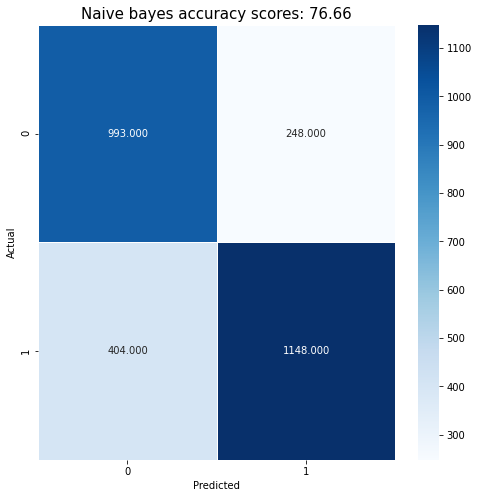

In [21]:
plt.figure(figsize=(8,8))
sns.heatmap(tree_cm, annot=True, cmap="Blues", fmt=".3f", linewidths=1)
plt.xlabel('Predicted')
plt.ylabel('Actual')
title="Naive bayes accuracy scores: {0}".format(round(accuracy,2))
plt.title(title, size=15)

In [25]:
trainData, testData = balancedData.randomSplit([0.7, 0.3])
print("So dong trong train data:", trainData.count())
print("So dong trong test data:", testData.count())

So dong trong train data: 6582
So dong trong test data: 2816


In [63]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [64]:
featureAssembler = VectorAssembler(
    inputCols=["age","gender","hypertension","heart_disease","work_type","Residence_type","avg_glucose_level","ever_married","smoking_status","bmi"],
    outputCol="features")
columns_to_drop = ["age","gender","hypertension","heart_disease","work_type","Residence_type","avg_glucose_level","ever_married","smoking_status","bmi"]
dt = DecisionTreeClassifier(labelCol="stroke", featuresCol="features")
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol="stroke")

In [65]:
import time
accuracyMLLIBNaiveBayesList = []
accuracyBuildNaiveBayesList = []
accuracyMLIBDecisionTreeList = []
timeMLLIBNaiveBayesList = []
timeBuildNaiveBayesList = []
timeMLIBDecisionTreeList = []
for i in range(10):
    trainData, testData = balancedData.randomSplit([0.7, 0.3])
#   For mllib 
    assembleredTestData = featureAssembler.transform(testData)
    assembleredTestData = assembleredTestData.drop(*columns_to_drop)
    assembleredTrainData = featureAssembler.transform(trainData)
    assembleredTrainData = assembleredTrainData.drop(*columns_to_drop)
#   Builded Naive Bayes
    start_time = time.time()
    accuracy, tree_cm = evaluate_algorithm(trainData, testData, naive_bayes)
    end_time = time.time()
    accuracyBuildNaiveBayesList.append(accuracy)
    timeBuildNaiveBayesList.append(end_time - start_time)
#   MLLIB NaiveBayes
    start_time = time.time()
    modelNaiveBayes = nb.fit(assembleredTrainData)
    predictions = modelNaiveBayes.transform(assembleredTestData)
    end_time = time.time()
    accuracy = evaluator.evaluate(predictions)
    accuracyMLLIBNaiveBayesList.append(accuracy * 100)
    timeMLLIBNaiveBayesList.append(end_time - start_time)
#   MLLIB Decision Tree
    start_time = time.time()
    modelDecisionTree = dt.fit(assembleredTrainData)
    predictions = modelDecisionTree.transform(assembleredTestData)
    end_time = time.time()
    accuracy = evaluator.evaluate(predictions)
    accuracyMLIBDecisionTreeList.append(accuracy * 100)
    timeMLIBDecisionTreeList.append(end_time - start_time)
     

In [66]:
evaluateAlgorithm = pd.DataFrame(accuracyBuildNaiveBayesList, columns =['Build Naive Bayes Accuracy'])
evaluateAlgorithm['Build Naive Bayes Time'] = timeBuildNaiveBayesList
evaluateAlgorithm['MLLIB Naive Bayes Accuracy'] = accuracyMLLIBNaiveBayesList
evaluateAlgorithm['MLLIB Naive Bayes Time'] = timeMLLIBNaiveBayesList
evaluateAlgorithm['MLLIB Decision Tree Accuracy'] = accuracyMLIBDecisionTreeList
evaluateAlgorithm['MLLIB Decision Tree Time'] = timeMLIBDecisionTreeList

In [67]:
evaluateAlgorithm.describe()

,Build Naive Bayes Accuracy,Build Naive Bayes Time,MLLIB Naive Bayes Accuracy,MLLIB Naive Bayes Time,MLLIB Decision Tree Accuracy,MLLIB Decision Tree Time
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,77.160344,12.334597,72.952034,0.886769,81.121940,0.824948
std,0.705861,1.185261,0.900120,0.331764,0.868574,0.201707
min,76.280421,10.878268,71.464556,0.527089,79.622230,0.578753
25%,76.551378,11.584418,72.445699,0.594311,80.698983,0.678396
50%,77.167556,12.261762,72.834277,0.847808,81.089603,0.767878
75%,77.580363,12.657318,73.704504,1.116331,81.764500,1.002636
max,78.573975,15.133346,74.152848,1.416265,82.342718,1.155464
